# Analyzing human transcriptome peptide predictions to assess the accuracy of peptigate

## Things that may impact the results shown here

### Peptigate expectedly and systematically misses previously annotated sORFs

We might be systematically missing sORFs that would be in the peptipedia database because we remove these from sORF detection at the beginning of peptigate.
The sORF detection module of peptigate starts by grabbing all transcripts (contigs) that do not have an annotated ORF (protein-coding gene).
Since human has many labeled sORFs in the RefSeq transcriptome, these would be removed as coding and not scanned.
This is in contrast to transdecoder-predicted ORFs in newly assembled transcriptomes, where transdecoder will not predict an ORF shorter than 100 amino acids.
While we thought about putting these sORFs back through peptigate just to make sure we detect them, we don't think it makes sense to do that since plmutils was trained in part on human data.

### Peptigate is not written to detect all peptides
We also explicitly do _not_ detect some types of peptides.
For example, we don't have a prediction step for tryptic peptides.
We also chose not to detect sORF encoded in the 5' and 3' UTR of coding transcripts, since these usually serve a regulatory role for the long, canonical ORF encoded on that transcript.

## Prep notebook

In [1]:
library(tidyverse, warn.conflicts = F)
library(ggExtra)
library(umap)
library(Rtsne)

── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
set.seed(42)

## Read in and process data

In [3]:
human_predictions <- read_tsv("../results/human/peptide_predictions.tsv.gz", show_col_types = F)

human_annotations <- read_tsv("../results/human/peptide_annotations.tsv.gz", show_col_types = F) %>%
  mutate(length = nchar(sequence)) %>%
  mutate(peptipedia_blast_result = ifelse(!is.na(peptipedia_blast_bitscore), "blast hit", "no blast hit"))

human_results <- left_join(human_predictions, human_annotations, by = "peptide_id")

In [4]:
# see how many predictions there were per tool
human_predictions %>%
  group_by(prediction_tool) %>%
  tally() %>%
  arrange(desc(n))

prediction_tool,n
<chr>,<int>
deeppeptide,4191
plmutils,2651
nlpprecursor,308


In [5]:
print(paste0("Total number of results: ", nrow(human_results)))
print(paste0("Total distinct peptide names: ", length(unique(human_results$peptide_id))))
print(paste0("Total distinct peptide sequences: ", length(unique(human_results$sequence))))

[1] "Total number of results: 7571"
[1] "Total distinct peptide names: 7150"
[1] "Total distinct peptide sequences: 4057"


## Filter to distinct peptide sequences

While there is no overlap in sequences predicted by different tools (code not shown), duplicate sequences arise from a tool (ex. DeepPeptide) predicting the same peptide sequence from different transcripts.
These transcripts are usually isoforms of the same gene that contain the same sequence that gives rise to the peptide.

Peptigate predicted 4,862 distinct peptide amino acid sequences.

In [40]:
# filter to distinct sequences
# requires removing metadata columns that might not be the same even if sequences are the same.
human_results_distinct <- human_results %>%
  select(-peptide_id, -start, -end, -peptipedia_blast_sseqid, -peptipedia_blast_full_sseq,
         -nlpprecursor_class_score, -nlpprecursor_cleavage_score, -peptipedia_num_hits) %>%
  select(peptide_type, peptide_class, prediction_tool, sequence, AB, ACE, ACP, 
         AF, AMAP, AMP, AOX, APP, AV, BBP, DPPIV, MRSA, Neuro, QS, TOX, TTCA, 
         aliphatic_index, boman_index, charge, hydrophobicity, instability_index, 
         isoelectric_point, molecular_weight, pd1_residue_volume, 
         pd2_hydrophilicity, z1_lipophilicity, z2_steric_bulk_or_polarizability,
         z3_polarity_or_charge, z4_electronegativity_etc, z5_electronegativity_etc, 
         peptipedia_blast_pident, peptipedia_blast_evalue, 
         peptipedia_blast_bitscore,  peptipedia_blast_result,
         length) %>%
  distinct()

In [ ]:
length(unique(human_results_distinct$sequence))
nrow(human_results_distinct)

In [46]:
human_results_duplicated <- human_results_distinct %>%
  group_by(sequence) %>%
  filter(n() > 1) %>%
  ungroup() %>%
  arrange(sequence)
human_results_duplicated

peptide_type,peptide_class,prediction_tool,sequence,AB,ACE,ACP,AF,AMAP,AMP,⋯,z1_lipophilicity,z2_steric_bulk_or_polarizability,z3_polarity_or_charge,z4_electronegativity_etc,z5_electronegativity_etc,peptipedia_blast_pident,peptipedia_blast_evalue,peptipedia_blast_bitscore,peptipedia_blast_result,length
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
cleavage,Peptide,deeppeptide,MMVRGRHRGLGQLSRDGRRGGGSGRGSGGGSGLPSGMPVPPGRDG,0.6666667,0.3333333,0.0000000,0,0.0000000,0.6666667,⋯,1.15288889,-1.21688889,-0.2797778,-0.03888889,0.1266667,NA,NA,NA,no blast hit,45
sORF,NA,plmutils,MMVRGRHRGLGQLSRDGRRGGGSGRGSGGGSGLPSGMPVPPGRDG,0.6666667,0.3333333,0.0000000,0,0.0000000,0.6666667,⋯,1.15288889,-1.21688889,-0.2797778,-0.03888889,0.1266667,NA,NA,NA,no blast hit,45
cleavage,Peptide,deeppeptide,MSYKPDMSKVGKFDREKLKKINNKEKNTLLPQETIQQEKEYIQTF,0.3333333,0.3333333,0.6666667,0,0.0000000,0.6666667,⋯,0.51622222,0.10933333,-0.6551111,-0.45777778,0.2497778,70.5,3.09e-13,58.2,blast hit,45
sORF,NA,plmutils,MSYKPDMSKVGKFDREKLKKINNKEKNTLLPQETIQQEKEYIQTF,0.3333333,0.3333333,0.6666667,0,0.0000000,0.6666667,⋯,0.51622222,0.10933333,-0.6551111,-0.45777778,0.2497778,70.5,3.09e-13,58.2,blast hit,45
cleavage,Peptide,deeppeptide,MYLGDSHVLLNTLCWCCHRKIWLHSGEDCYHCRTEPLRP,0.0000000,0.3333333,0.0000000,0,0.3333333,0.6666667,⋯,0.06179487,-0.04794872,0.1605128,0.22461538,-0.2184615,NA,NA,NA,no blast hit,39
sORF,NA,plmutils,MYLGDSHVLLNTLCWCCHRKIWLHSGEDCYHCRTEPLRP,0.0000000,0.3333333,0.0000000,0,0.3333333,0.6666667,⋯,0.06179487,-0.04794872,0.1605128,0.22461538,-0.2184615,NA,NA,NA,no blast hit,39


There are 3 sequences that were predicted by plmutils and deeppeptide.
I'm going to keep the deeppeptide ones for the rest of the notebook to simplify calculations.

In [49]:
nrow(human_results_distinct)

[1] 4060

In [55]:
human_results_distinct <- human_results_distinct %>%
  filter(!(peptide_type == "sORF" & sequence %in% human_results_duplicated$sequence))

In [56]:
length(unique(human_results_distinct$sequence))
nrow(human_results_distinct)

[1] 4057

[1] 4057

In [57]:
human_results_distinct %>%
  group_by(prediction_tool) %>%
  tally() %>%
  arrange(desc(n))

prediction_tool,n
<chr>,<int>
plmutils,2172
deeppeptide,1681
nlpprecursor,204


## Compare to BLAST results

### Peptides predicted by different tools have varying hit rates against the Peptipedia database

To try and determine how many peptides we predicted are real peptides, we looked at peptigate-reported BLAST results.
Peptigate BLASTs (`blastp`) each peptide against the Peptipedia database.
Peptipedia is a super database that contains peptide sequences from 86 sources, including other databases and large-scale papers.

33% of DeepPeptide predictions, 45% of NLPPrecursor predictions, and 13% of plmutils predictions had hits against peptides in the Peptipedia database.

|prediction_tool |peptipedia_blast_result |    n|
|:---------------|:-----------------------|----:|
|deeppeptide     |blast hit               |  559|
|deeppeptide     |no blast hit            | 1122|
|nlpprecursor    |blast hit               |   91|
|nlpprecursor    |no blast hit            |  113|
|plmutils        |blast hit               |  279|
|plmutils        |no blast hit            | 1893|

It's unclear what a "good" expected hit rate is here.
We expect some hits, as we would expect some fraction of our predicted peptides to have been previously discovered.
However, it's unclear how many bioactive peptides exist, or how many have been discovered.
A mass spec/ML paper published in Nature Communications in 2022 suggested that to date only 300 peptides in humans have confirmed bioactivity (https://doi.org/10.1038/s41467-022-34031-z), which suggests that our predictions aren't many orders of magnitude away from expectation and that there may be room for new human peptide discovery.
Indeed, 183 peptides with BLAST hits in Peptipedia had a BLAST percent identity < 100%, suggesting these may be new peptides that are related to those previously discovered.
The same nature paper mentioned above also stated that specific enzymatic cleavages of protein precursors form most bioactive peptides, so it is promising that our cleavage tools (deeppeptide and nlpprecursor) have high hit rates against the Peptipedia database.

Note this quote from the DeepPeptide paper, which supports the idea that over-prediction relative to recorded references is a known phenomenon as peptides are notoriously under-annotated in databases.

> To validate the performance of DeepPeptide in its likely use case, the discovery of peptides in proteomes without prior knowledge, we applied it to 48 curated reference proteomes of eukaryotic organisms from the Quest for Orthologs project (Altenhoff 2016). Throughout all organisms, we observe that the number of predicted peptides and propeptides is mostly higher than what is annotated in UniProt for the same set of proteins (Table 3 and Supplementary Table S3). As evident from the large number of proteomes that have zero peptides annotated, this is likely due the fact that peptides are vastly underannotated in UniProt, as their only source is manual curation from literature. Given the cross-validated precision of 0.69 of DeepPeptide, it can be assumed that the majority of the predicted peptides are correct, and the model reasonably estimates the order of magnitude of peptide prevalence in underannotated proteomes.

We think that plmutils may have an especially low BLAST hit rate because, as noted at the top of this notebook, we remove annotated protein-coding transcripts as the first step in the sORF discovery pipeline.
This means that if an sORF is annotated as protein-coding in the human reference transcriptome, we won't detect it.
While we were developing plmutils, I frequently checked to see how up-to-date the human annotations were.
Most sORFs that I found in the literature that were shown to be coding already had annotations propagated back to human references, so I think sORFs that we annotate here, if real, are new.

In [58]:
# annotate whether there was a BLAST hit in peptipedia or not (tbd if that is the best database to use for human peptides)
human_blast_results <- human_results_distinct %>%
  select(sequence, length, prediction_tool, starts_with("peptipedia_blast")) %>%
  distinct()

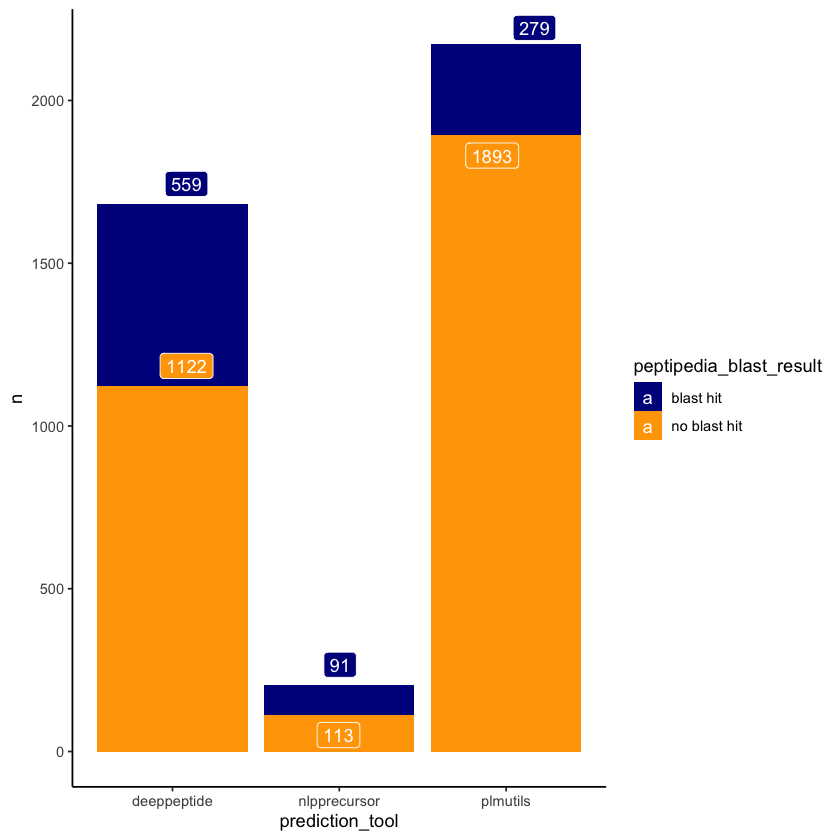

In [59]:
human_blast_results_tally1 <- human_blast_results %>%
  group_by(prediction_tool, peptipedia_blast_result) %>%
  tally()

ggplot(human_blast_results_tally1, aes(x = prediction_tool, y = n, fill = peptipedia_blast_result)) +
  geom_col() +
  ggrepel::geom_label_repel(aes(label = n), position = position_stack(), color = "white") +
  theme_classic() +
  scale_fill_manual(values = c("blast hit" = "blue4", "no blast hit" = "orange"))

### Cumulative bioactivity prediction

In [60]:
human_results_distinct <- human_results_distinct %>% 
  rowwise() %>% 
  mutate(bioactivity_sum = sum(c_across(c(AB, ACE, ACP, AF, AMAP, AMP, AOX, APP,
                                          AV, BBP, DPPIV, MRSA, Neuro, QS, TOX, 
                                          TTCA)),
                               na.rm = TRUE)) %>%
  ungroup()

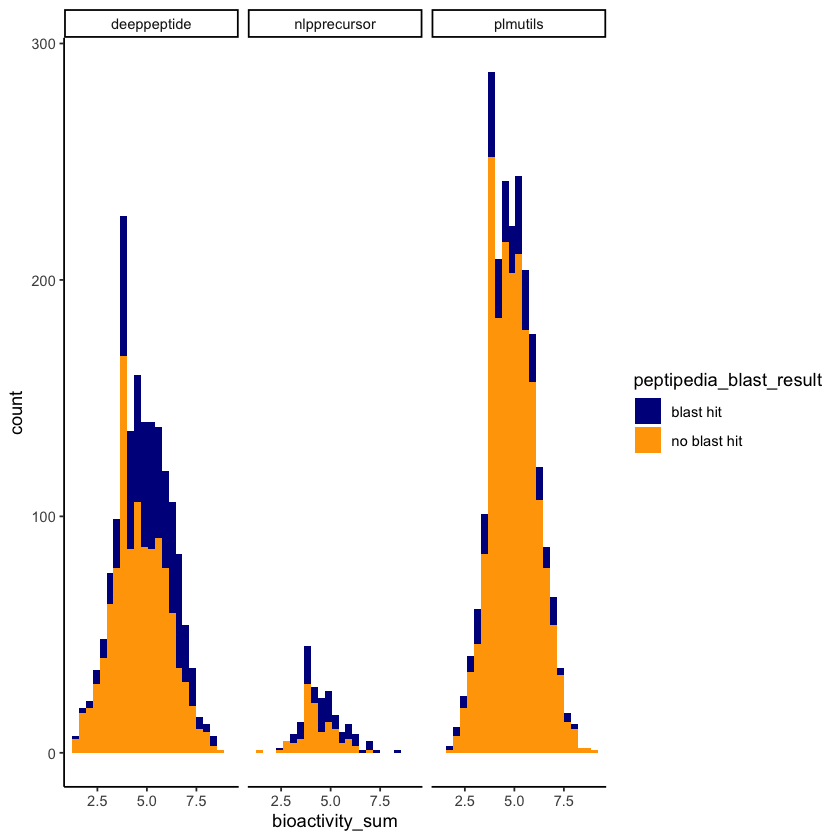

In [61]:
ggplot(human_results_distinct, aes(x = bioactivity_sum, fill = peptipedia_blast_result)) +
  geom_histogram(bins = 23) +
  theme_classic() +
  facet_wrap(~prediction_tool) +
  scale_fill_manual(values = c("blast hit" = "blue4", "no blast hit" = "orange"))

In [62]:
bioactivity_sum_df <- human_results_distinct %>%
  group_by(peptipedia_blast_result, prediction_tool) %>%
  summarise(mean_bioactivity_sum = mean(bioactivity_sum, na.rm = TRUE),
            median_bioactivity_sum = median(bioactivity_sum, na.rm = TRUE),
            sd_bioactivity_sum = sd(bioactivity_sum, na.rm = TRUE))

bioactivity_sum_df %>% mutate(across(where(is.numeric), ~round(., 1)))

`summarise()` has grouped output by 'peptipedia_blast_result'. You can override using the `.groups` argument.


peptipedia_blast_result,prediction_tool,mean_bioactivity_sum,median_bioactivity_sum,sd_bioactivity_sum
<chr>,<chr>,<dbl>,<dbl>,<dbl>
blast hit,deeppeptide,5.2,5.3,1.3
blast hit,nlpprecursor,4.8,4.7,1.1
blast hit,plmutils,4.8,5.0,1.3
no blast hit,deeppeptide,4.7,4.7,1.4
no blast hit,nlpprecursor,4.4,4.3,1.0
no blast hit,plmutils,5.0,5.0,1.2


In [63]:
nested_data <- human_results_distinct %>%
  group_by(prediction_tool) %>%
  nest()

perform_t_test <- function(df) {
  test_result <- t.test(bioactivity_sum ~ peptipedia_blast_result, data = df)
  return(list(p_value = test_result$p.value))
}

test_results <- nested_data %>%
  mutate(test_result = map(data, perform_t_test))

test_results <- unnest(test_results, test_result)
print(test_results)
print(test_results$test_result)

# A tibble: 3 × 3
# Groups:   prediction_tool [3]
  prediction_tool data                  test_result 
  <chr>           <list>                <named list>
1 nlpprecursor    <tibble [204 × 39]>   <dbl [1]>   
2 deeppeptide     <tibble [1,681 × 39]> <dbl [1]>   
3 plmutils        <tibble [2,172 × 39]> <dbl [1]>   
$p_value
[1] 0.007093834

$p_value
[1] 5.20578e-15

$p_value
[1] 0.04775361



### Number of bioactivities predicted

In [64]:
human_results_distinct <- human_results_distinct %>% 
  rowwise() %>% 
  mutate(bioactivity_non_zero_count = sum(c_across(c(AB, ACE, ACP, AF, AMAP, AMP,
                                                     AOX, APP, AV, BBP, DPPIV, 
                                                     MRSA, Neuro, QS, TOX, TTCA)) != 0, 
                                          na.rm = TRUE)) %>%
  ungroup()

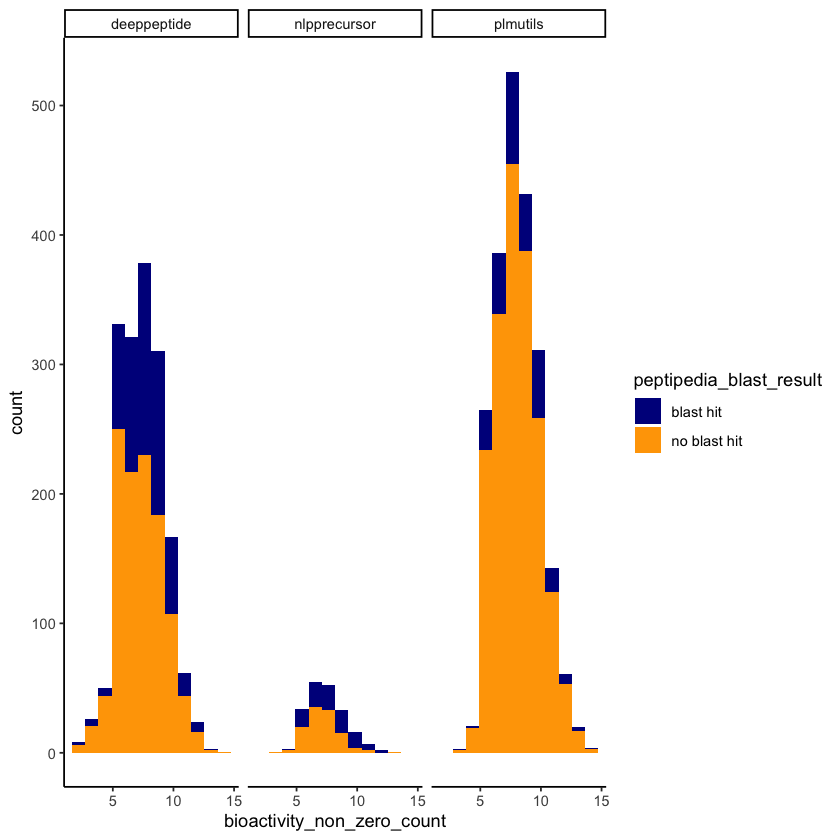

In [65]:
ggplot(human_results_distinct, aes(x = bioactivity_non_zero_count, fill = peptipedia_blast_result)) +
  geom_histogram(bins = 12) +
  theme_classic() +
  facet_wrap(~prediction_tool) +
  scale_fill_manual(values = c("blast hit" = "blue4", "no blast hit" = "orange"))

In [66]:
bioactivity_nonzerocount_df <- human_results_distinct %>%
  group_by(peptipedia_blast_result, prediction_tool) %>%
  summarise(mean_bioactivity_non_zero_count = mean(bioactivity_non_zero_count, na.rm = TRUE),
            median_bioactivity_non_zero_count = median(bioactivity_non_zero_count, na.rm = TRUE),
            sd_bioactivity_non_zero_count = sd(bioactivity_non_zero_count, na.rm = TRUE))

bioactivity_nonzerocount_df %>% mutate(across(where(is.numeric), ~round(., 1)))

`summarise()` has grouped output by 'peptipedia_blast_result'. You can override using the `.groups` argument.


peptipedia_blast_result,prediction_tool,mean_bioactivity_non_zero_count,median_bioactivity_non_zero_count,sd_bioactivity_non_zero_count
<chr>,<chr>,<dbl>,<dbl>,<dbl>
blast hit,deeppeptide,8.0,8,1.6
blast hit,nlpprecursor,8.1,8,1.6
blast hit,plmutils,8.5,8,1.8
no blast hit,deeppeptide,7.5,8,2.0
no blast hit,nlpprecursor,7.5,7,1.5
no blast hit,plmutils,8.3,8,1.7


In [67]:
nested_data <- human_results_distinct %>%
  group_by(prediction_tool) %>%
  nest()

# perform t-tests within each 'prediction_tool' group
perform_t_test <- function(df) {
  test_result <- t.test(bioactivity_non_zero_count ~ peptipedia_blast_result, data = df)
  return(list(p_value = test_result$p.value))
}

# Apply the t-test function to each subset
test_results <- nested_data %>%
  mutate(test_result = map(data, perform_t_test))
test_results <- unnest(test_results, test_result)
print(test_results)
print(test_results$test_result)

# A tibble: 3 × 3
# Groups:   prediction_tool [3]
  prediction_tool data                  test_result 
  <chr>           <list>                <named list>
1 nlpprecursor    <tibble [204 × 40]>   <dbl [1]>   
2 deeppeptide     <tibble [1,681 × 40]> <dbl [1]>   
3 plmutils        <tibble [2,172 × 40]> <dbl [1]>   
$p_value
[1] 0.004429699

$p_value
[1] 9.785396e-07

$p_value
[1] 0.2364004



## Do some short sORF peptides have BLAST hits against other databases?

We extracted some short ORFs and used web interfaces (NCBI, UniProt) to BLAST the peptides to see if there were any peptide hits.
We didn't find anything interesting for any of the peptides we tried (we probably ran ~5).

In [68]:
short_no_hit <- human_blast_results %>%
  mutate(peptipedia_blast_result = ifelse(!is.na(peptipedia_blast_bitscore), "blast hit", "no blast hit")) %>%
  filter(length < 31) %>%
  filter(peptipedia_blast_result == "no blast hit")

nrow(short_no_hit)
length(unique(short_no_hit$sequence))

[1] 1053

[1] 1053

In [69]:
head(short_no_hit$sequence)

[1] "PTSTPYLLFYKKL"            "WKRANSIFRNFLRLKSSRNTAEAE"
[3] "NQAHRHSAGSSSKLWFPSKLI"    "IAASIPEDCQAPLQPHSTDCCS"  
[5] "HGGSGSLSIIKSKIPTYCSICC"   "WRDIPGGLFGRVHHSARWLGHCV"

## Do peptides cluster together?

If peptides cluster together, this suggests that peptide predictions are in the realm of biological possibility, even if they do not have a BLAST hit in the peptipedia database.
When we use PCA, UMAP, or tSNE, we don't see defined clusters of peptides.
However, we do see that peptides with BLAST hits are continuous with peptides with non-BLAST hits, providing some evidence that these peptides might be real.

The clustering below is based on peptide characterization information, including:
aliphatic_index: relative volume occupied by aliphatic side chains (Alanine, Valine, Isoleucine, and Leucine).
boman_index: The potential interaction index proposed by Boman (2003) is an index computed by averaging the solubility values for all residues in a sequence. It can be used to give an overall estimate of the potential of a peptide to bind to membranes or other proteins. A value greater than 2.48 indicates that a protein has a high binding potential.
charge: the theoretical net charge of a peptide sequence based on the Henderson-Hasselbach equation. Computed at a pH of 7 with the Lehninger pKscale.
hydrophobicity: average of the hydrophobicity values of each residue using one of the 39 scales from different sources.
instability_index: predicts the stability of a protein based on its dipeptide composition. A protein whose instability index is smaller than 40 is predicted as stable, a value above 40 predicts that the protein may be unstable.
isoelectric_point: the pH at which a particular molecule or surface carries no net electrical charge.
molecular_weight: the sum of the mass of each amino acid in the peptide sequence.
pd1_residue_volume: physical descriptor related to the peptide residue volume.
pd2_hydrophilicity: physical descriptor related to the peptide hydrophilicity.
z1_lipophilicity: Zscale quantifying the lipophilicity of the peptide.
z2_steric_bulk_or_polarizability: Zscale modeling steric properties like steric bulk and polarizability.
z3_polarity_or_charge: Zscale quantifying electronic properties like polarity and charge.
z4_electronegativity_etc: Zscale relating to electronegativity, heat of formation, electrophilicity, and hardness.
z5_electronegativity_etc: Zscale relating to electronegativity, heat of formation, electrophilicity, and hardness.
length: length in amino acids of the peptide.

## PCA

In [70]:
human_results_distinct_pca <- human_results_distinct %>% 
  select(prediction_tool, peptipedia_blast_result, aliphatic_index, boman_index,
         charge, hydrophobicity, instability_index, isoelectric_point, 
         molecular_weight, pd1_residue_volume, pd2_hydrophilicity, 
         z1_lipophilicity, z2_steric_bulk_or_polarizability, 
         z3_polarity_or_charge, z4_electronegativity_etc, 
         z5_electronegativity_etc, length) 

In [71]:
human_results_distinct_pca_scaled <- scale(human_results_distinct_pca %>% select(where(is.numeric)))
human_results_distinct_pca_result <- prcomp(human_results_distinct_pca_scaled , center = TRUE, scale. = TRUE)
summary(human_results_distinct_pca_result)

Importance of components:
                          PC1    PC2    PC3    PC4     PC5     PC6     PC7
Standard deviation     2.1372 1.7917 1.5559 1.2389 1.08988 0.95396 0.73740
Proportion of Variance 0.3045 0.2140 0.1614 0.1023 0.07919 0.06067 0.03625
Cumulative Proportion  0.3045 0.5185 0.6799 0.7822 0.86142 0.92209 0.95834
                           PC8    PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     0.53044 0.3653 0.34701 0.25078 0.12128 0.08282 0.05138
Proportion of Variance 0.01876 0.0089 0.00803 0.00419 0.00098 0.00046 0.00018
Cumulative Proportion  0.97710 0.9860 0.99402 0.99821 0.99919 0.99965 0.99983
                          PC15
Standard deviation     0.05095
Proportion of Variance 0.00017
Cumulative Proportion  1.00000

In [72]:
human_results_distinct_pca_scores <- as.data.frame(human_results_distinct_pca_result$x)

human_results_distinct_pca_scores_with_metadata <- cbind(human_results_distinct_pca_scores,
                                                         human_results_distinct_pca)

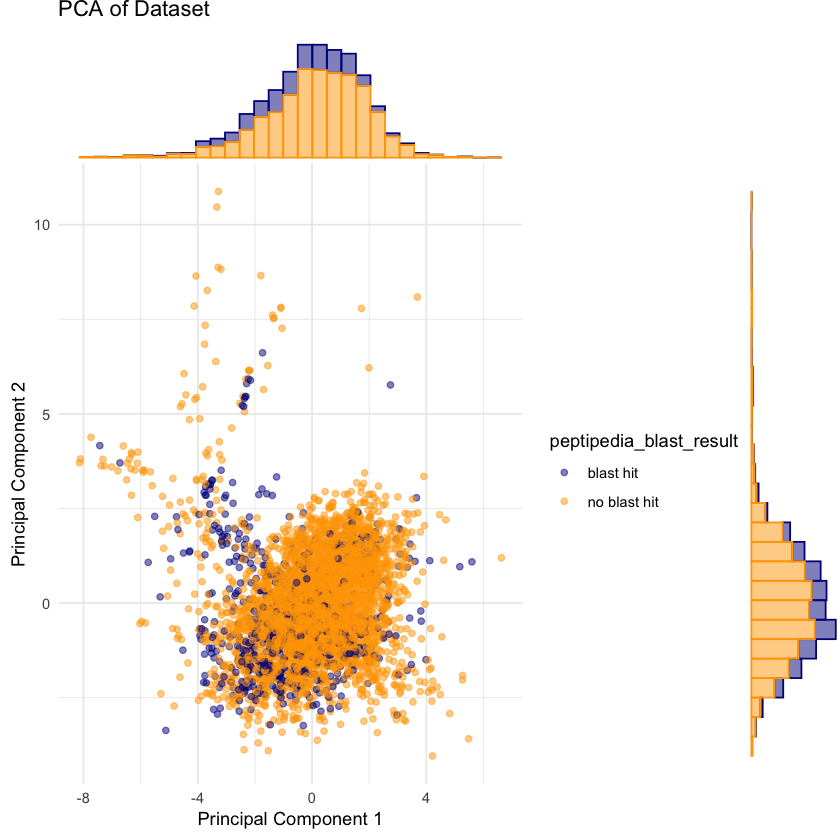

In [73]:
plt1 <- ggplot(human_results_distinct_pca_scores_with_metadata, aes(x = PC2, y = PC3, color = peptipedia_blast_result)) +
  geom_point(alpha = .5) +
  theme_minimal() +
  labs(title = "PCA of Dataset", x = "Principal Component 1", y = "Principal Component 2") +
  scale_color_manual(values = c("blast hit" = "blue4", "no blast hit" = "orange"))

ggMarginal(plt1, type = "histogram", groupColour = T, groupFill = T)

## tSNE

In [74]:
tsne_result <- Rtsne(human_results_distinct_pca_scaled, perplexity = 5)
tsne_data <- as.data.frame(tsne_result$Y)
tsne_data <- cbind(tsne_data, human_results_distinct_pca)

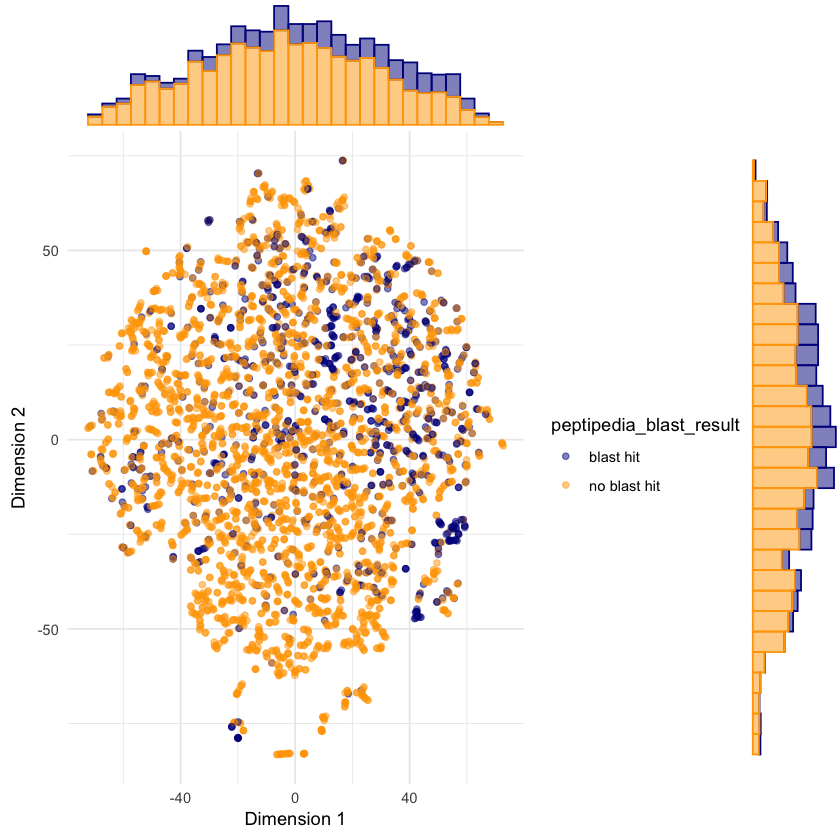

In [75]:
plt3 <- ggplot(tsne_data, aes(x = V1, y = V2, color = peptipedia_blast_result)) +
  geom_point(alpha = 0.5) +
  theme_minimal() +
  labs(x = "Dimension 1", y = "Dimension 2") +
  scale_color_manual(values = c("blast hit" = "blue4", "no blast hit" = "orange"))

ggExtra:: ggMarginal(plt3, type = "histogram", groupColour = TRUE, groupFill = T)

## UMAP

In [77]:
umap_result <- umap(human_results_distinct_pca_scaled, n_neighbors = 5, min_dist = 0.5)
umap_data <- data.frame(UMAP1 = umap_result$layout[,1], UMAP2 = umap_result$layout[,2])
umap_data <- cbind(umap_data, human_results_distinct_pca)

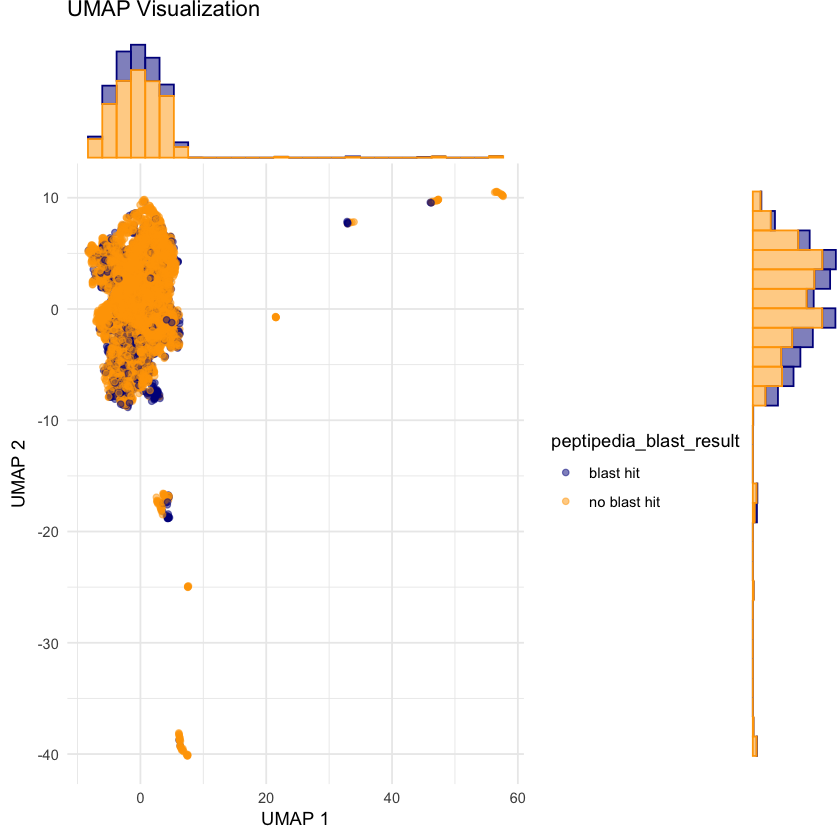

In [78]:
plt2 <- ggplot(umap_data, aes(x = UMAP1, y = UMAP2, color = peptipedia_blast_result)) +
  geom_point(alpha = 0.5) +
  theme_minimal() +
  labs(title = "UMAP Visualization", x = "UMAP 1", y = "UMAP 2") +
  scale_color_manual(values = c("blast hit" = "blue4", "no blast hit" = "orange"))

ggExtra:: ggMarginal(plt2, type = "histogram", groupColour = TRUE, groupFill = T)

### Make a per-prediction tool umap plot to see if we get better clustering

#### NLPPrecursor

In [79]:
nlpprecursor <- human_results_distinct_pca_scaled[human_results_distinct$prediction_tool == "nlpprecursor", ] 
nlpprecursor_umap_result <- umap(nlpprecursor, n_neighbors = 9, min_dist = 0.1)
nlpprecursor_umap_data <- data.frame(UMAP1 = nlpprecursor_umap_result$layout[,1], UMAP2 = nlpprecursor_umap_result$layout[,2])
nlpprecursor_umap_data <- cbind(nlpprecursor_umap_data, human_results_distinct[human_results_distinct$prediction_tool == "nlpprecursor", ])

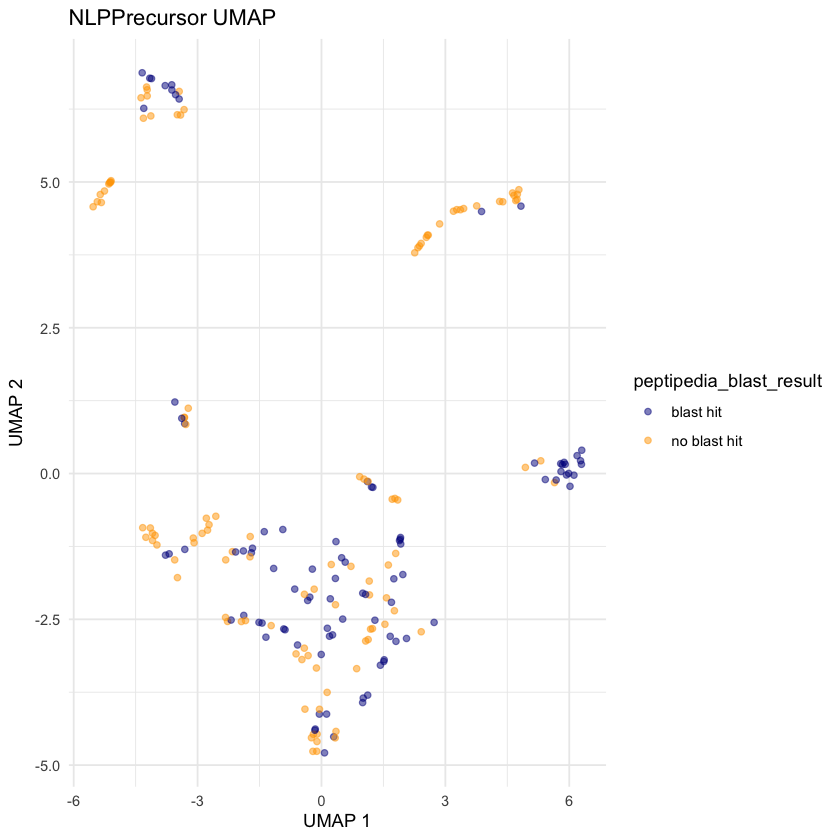

In [80]:
ggplot(nlpprecursor_umap_data, aes(x = UMAP1, y = UMAP2, color = peptipedia_blast_result)) +
  geom_point(alpha = 0.5) +
  theme_minimal() +
  labs(title = "NLPPrecursor UMAP", x = "UMAP 1", y = "UMAP 2") +
  scale_color_manual(values = c("blast hit" = "blue4", "no blast hit" = "orange"))

#### DeepPeptide

In [81]:
deeppeptide <- human_results_distinct_pca_scaled[human_results_distinct$prediction_tool == "deeppeptide", ] 
deeppeptide_umap_result <- umap(deeppeptide, n_neighbors = 5, min_dist = 0.05)
deeppeptide_umap_data <- data.frame(UMAP1 = deeppeptide_umap_result$layout[,1], UMAP2 = deeppeptide_umap_result$layout[,2])
deeppeptide_umap_data <- cbind(deeppeptide_umap_data, human_results_distinct[human_results_distinct$prediction_tool == "deeppeptide", ])

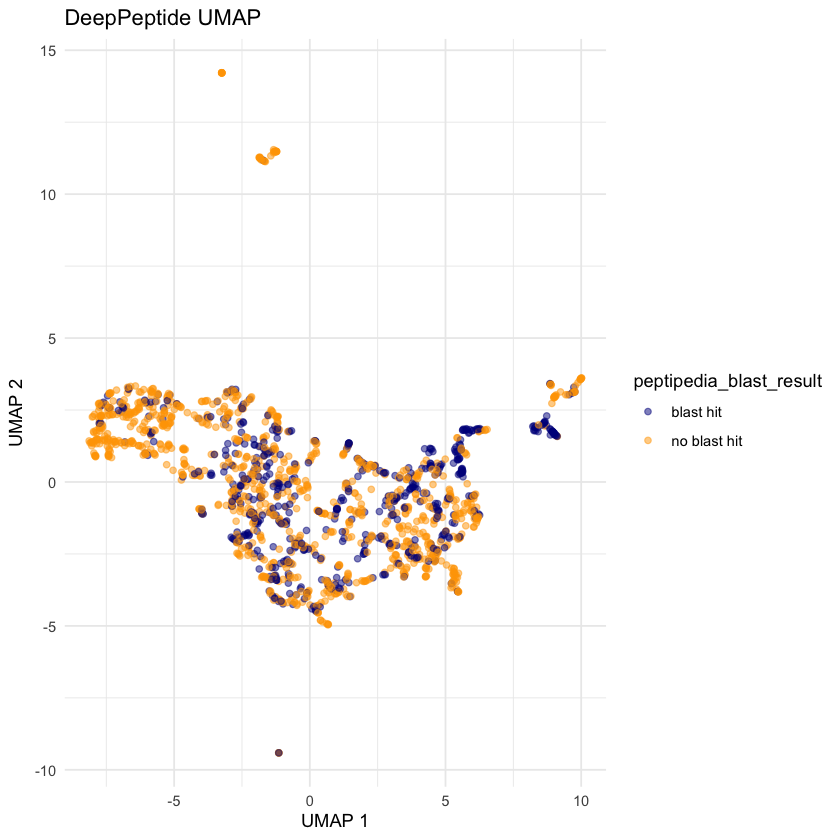

In [82]:
ggplot(deeppeptide_umap_data, aes(x = UMAP1, y = UMAP2, color = peptipedia_blast_result)) +
  geom_point(alpha = 0.5) +
  theme_minimal() +
  labs(title = "DeepPeptide UMAP", x = "UMAP 1", y = "UMAP 2") +
  scale_color_manual(values = c("blast hit" = "blue4", "no blast hit" = "orange"))

#### plm-utils

In [83]:
plmutils <- human_results_distinct_pca_scaled[human_results_distinct$prediction_tool == "plmutils", ] 
plmutils_umap_result <- umap(plmutils, n_neighbors = 4, min_dist = 0.1)
plmutils_umap_data <- data.frame(UMAP1 = plmutils_umap_result$layout[,1], UMAP2 = plmutils_umap_result$layout[,2])
plmutils_umap_data <- cbind(plmutils_umap_data, human_results_distinct[human_results_distinct$prediction_tool == "plmutils", ])

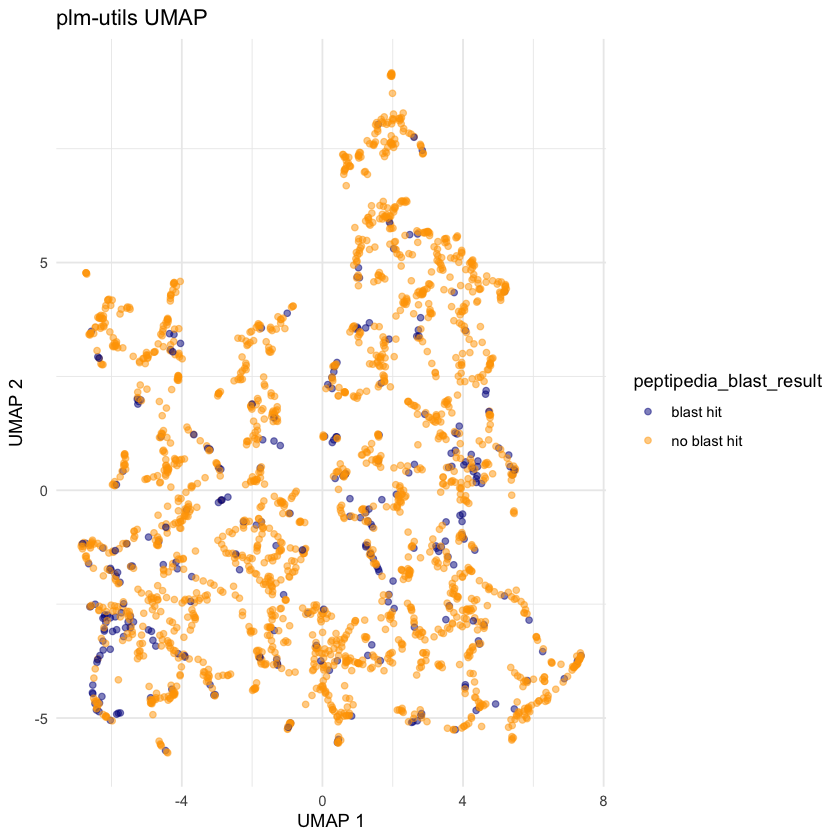

In [84]:
ggplot(plmutils_umap_data, aes(x = UMAP1, y = UMAP2, color = peptipedia_blast_result)) +
  geom_point(alpha = 0.5) +
  theme_minimal() +
  labs(title = "plm-utils UMAP", x = "UMAP 1", y = "UMAP 2") +
  scale_color_manual(values = c("blast hit" = "blue4", "no blast hit" = "orange"))

## More notes about these results

It's worth considering how these results may differ for human than for other organisms.
DeepPeptide and plmutils were both trained with human data (deeppeptide on uniprot release 2022_01, plmutils on Ensembl model organisms).
NLPPrecursor was trained on bacterial sequences only.
This means that DeepPeptide and plmutils might both be more likely to perform well on human data.
We are probably more likely to have BLAST hits for human sequences given that humans have been studied extensively.
Similarly, we expect that most of the bioactivity models were trained on human data as well, which might overinflate or otherwise bias the bioactivity results.

(hammering this point home a third time) It is also not surprising that plmutils has relatively fewer BLAST hits than DeepPeptide and NLPPrecursor.
The peptigate pipeline was built with the assumption that we want to detect sORFs that are not already annotated in a transcriptome.
As such, it scans contiguous sequences that *do not* have an open reading frame that has already been annotated.
Typically, we expect ORF annotation to occur via a tool like transdecoder which does not annotate ORFs smaller than 100 amino acids (300 nucleotides).
However, for this input test, we used the human RefSeq transcriptome and labeled genes.
These files are better annotated than for probably any other species (perhaps second to mouse).
While we were building the peptigate pipeline, we confirmed that the human reference lists many sORFs as coding, and as such, we would not detect them via this pipeline because of our initial filtering steps.
We chose not to go back and fix this here because plmutils was trained on human data and so would likely regurgitate existing labels.

## Unresolved questions

### How many (bioactive) peptides are in the human proteome?

As stated above, a recent paper suggested 300 bioactive peptides have been found/validated in the human proteome.
It's difficult to gauge how much over-prediction we might have without a biological ceiling for our estimates.

### Should we expect to identify new human bioactive peptides with peptigate?

While we wrote peptigate to predict peptides from transcriptomes, it's not clear to us whether we should expect to identify new bioactive peptides in the human transcriptome.
I would guess yes, but it's difficult to say.

### How many peptides did we miss?

While comparing against a database of known peptides lets us know that at least some of the peptides we predict are probably real, we don't have a way to estimate how many peptides we did not predict (see point 1).

In [85]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/taylorreiter/miniconda3/envs/pepeval/lib/libopenblasp-r0.3.26.dylib;  LAPACK version 3.12.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/New_York
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] Rtsne_0.17      umap_0.2.10.0   ggExtra_0.10.0  lubridate_1.9.3
 [5] forcats_1.0.0   stringr_1.5.1   dplyr_1.1.4     purrr_1.0.2    
 [9] readr_2.1.5     tidyr_1.3.1     tibble_3.2.1    ggplot2_3.5.0  
[13] tidyverse_2.0.0

loaded via a namespace (and not attached):
 [1] utf8_1.2.4        generics_0.1.3    lattice_0.22-6    stringi_1.8.3    
 [5] hms_1.1.3         digest_0.6.35     magrittr_2.0.3    evaluate_0.23    
 [9] grid_4.3.3        timechange_0.3.0  pbdZMQ_0.3-11     fastmap_1.1